# Load H5/NC files directly into tensorflow

The dataset is to large to load into memory directly. Therefor we will define a generator first that can be used to get a part of the dataset

In [3]:
import h5py
import tensorflow as tf
import numpy as np
from datetime import datetime, timedelta
import netCDF4 

import matplotlib.pyplot as plt

In [4]:
# plots input and output of the model
def plotIO(x,y):
    n = len(x) + len(y)
    plt.figure(figsize=(10,10))
    h = 2
    w = max(len(x),len(y))
    for i, rdr in enumerate(x):
        plt.subplot(h, w, i+1)
        
        mask= (rdr == 65535)
        mx = np.ma.masked_array(rdr, mask)
        plt.imshow(np.squeeze(mx))
        plt.axis('off')
        
    for i, rdr in enumerate(y):
        plt.subplot(h, w, w + i+1)
        
        mask= (rdr == 65535)
        mx = np.ma.masked_array(rdr, mask)
        plt.imshow(np.squeeze(mx))
        plt.axis('off')    
    plt.show()

In [5]:
# Based upon the following code:
# https://stackoverflow.com/questions/48309631/tensorflow-tf-data-dataset-reading-large-hdf5-files

class generator:
    def __init__(self, filenames):
        self.x_fns, self.y_fns = filenames
        self.x_path = '/nobackup/users/schreurs/project_GAN/dataset_radar'
        self.y_path = '/nobackup/users/schreurs/project_GAN/dataset_aart'

    def __call__(self):
        x = self.get_x()
        y = self.get_y()
        yield x,y
        
    def get_x(self):
        '''
        Return a sequence of input radar scans
        '''
        x_seq =[]
        for fn in self.x_fns:
            path = self.x_path + '/RAD_NL25_RAC_RT_{}.h5'.format(fn)

            with h5py.File(path, 'r') as f:
                rain = f['image1']['image_data'][:]
                # Expand dimensions from (w,h) to (w,h,c)
                rain = np.expand_dims(rain, axis=-1)
                x_seq.append(rain)
        return x_seq
        
    def get_y(self):
        y_seq =[]
        for fn in self.y_fns:
            path = self.y_path + '/RAD_NL25_RAC_MFBS_EM_5min_{}.nc'.format(fn)

            with netCDF4.Dataset(path, 'r') as f:
                rain = f['image1_image_data'][:]

                # Change to image format (w,h,c) instead of (c,w,h)
                rain = np.moveaxis(rain, 0, -1)
                y_seq.append(rain)
        return y_seq

In [6]:
def filenames_xy(dt, x_size=3, y_size=1):
    '''
    Returns the filenames of the input x and target y.
    dt: datetime of sample (year month day hour minute)
    x_size: how many samples to take before datetime
    y_size: how many samples to take after datetime 
    '''
    xs = []
    for i in range(x_size,0,-1):
        dt_i = dt - i*timedelta(minutes=5)
        ts = '{:%Y%m%d%H%M}'.format(dt_i)
        xs.append(ts)
        
    ys = []
    for i in range(0,y_size,1):
        dt_i = dt + i*timedelta(minutes=5)
        ts = '{:%Y%m%d%H%M}'.format(dt_i)
        ys.append(ts)
    return xs,ys

a = datetime(year=2020, month=1,day=15,hour=14, minute=0)
fns = filenames_xy(a, y_size=3)
fns

(['202001151345', '202001151350', '202001151355'],
 ['202001151400', '202001151405', '202001151410'])

In [7]:
def create_ds(dt, x_size=3,y_size=1):
    fns = filenames_xy(dt,x_size,y_size)
    print(fns)
    x_type = tf.uint16
    y_type= tf.float32 
    x_shape = tf.TensorShape([x_size, 765, 700, 1])
    y_shape = tf.TensorShape([y_size,765, 700, 1])
    
    ds = tf.data.Dataset.from_generator(
        generator(fns), 
        output_types= (x_type, y_type),
        output_shapes= (x_shape, y_shape),
        )
    return ds

(['202001151345', '202001151350', '202001151355'], ['202001151400'])
(3, 765, 700, 1) (1, 765, 700, 1)


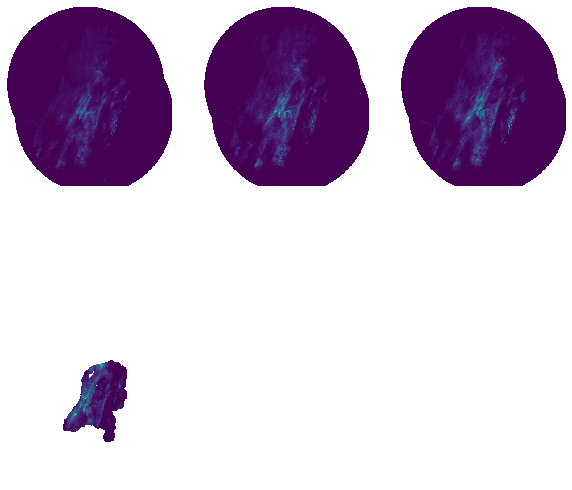

In [8]:
dt = datetime(year=2020, month=1,day=15,hour=14, minute=0)
d = create_ds(dt,x_size=3,y_size=1)

for element in d:
    x, y = element
    print(x.shape,y.shape)
    plotIO(x,y)

# Converting to Keras

The next step is to use the previous code to create a DataGenerator object in keras. This object can then yield samples on the fly during training. 

The code below is adapted from [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) and I am currently rewriting it to fit the current project

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, 
                 img_dim = (765, 700, 1), x_seq_size=3, y_seq_size=1, shuffle=True,
                x_path = '/nobackup/users/schreurs/project_GAN/dataset_radar',
                y_path = '/nobackup/users/schreurs/project_GAN/dataset_aart'):
        'Initialization'
        self.inp_shape = (x_seq_size, *img_dim)
        self.out_shape = (y_seq_size, *img_dim)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()
        self.x_path = x_path
        self.y_path = y_path

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # Initialization
        X = np.empty((self.batch_size, *self.inp_shape))
        y = np.empty((self.batch_size, *self.out_shape))
        
        # Generate data
        for i, IDs in enumerate(list_IDs_temp):
            x_IDs, y_IDs = IDs
            
            # Store input image(s)
            for c in range(self.inp_shape[0]):
                X[i,c] = self.load_x(x_IDs[c])

            # Store target image(s)
            for c in range(self.out_shape[0]):
                y[i,c] = self.load_y(y_IDs[c])

        return X, y
    
    def load_x(self, x_ID):
        path = self.x_path + '/RAD_NL25_RAC_RT_{}.h5'.format(x_ID)
        with h5py.File(path, 'r') as f:
            rain = f['image1']['image_data'][:]
            # Expand dimensions from (w,h) to (w,h,c=1)
            rain = np.expand_dims(rain, axis=-1)
            return rain
        
    def load_y(self, y_ID):
        path = self.y_path + '/RAD_NL25_RAC_MFBS_EM_5min_{}.nc'.format(y_ID)

        with netCDF4.Dataset(path, 'r') as f:
            rain = f['image1_image_data'][:]

            # Change to image format (w,h,c) instead of (c,w,h)
            rain = np.moveaxis(rain, 0, -1)
            return rain

In [10]:
# Create list of IDs to retrieve
x_seq_size=3
y_seq_size=1
# Create datetime object from start date till end date
start_dt = datetime(2020,1,15,14)
end_dt =  datetime(2020,1,15,16)
dts = np.arange( start_dt,
                end_dt, 
                timedelta(minutes=5*x_seq_size)).astype(datetime)
# Convert to filenames
list_IDs = [filenames_xy(dt,x_seq_size,y_seq_size) for dt in dts]
list_IDs 

[(['202001151345', '202001151350', '202001151355'], ['202001151400']),
 (['202001151400', '202001151405', '202001151410'], ['202001151415']),
 (['202001151415', '202001151420', '202001151425'], ['202001151430']),
 (['202001151430', '202001151435', '202001151440'], ['202001151445']),
 (['202001151445', '202001151450', '202001151455'], ['202001151500']),
 (['202001151500', '202001151505', '202001151510'], ['202001151515']),
 (['202001151515', '202001151520', '202001151525'], ['202001151530']),
 (['202001151530', '202001151535', '202001151540'], ['202001151545'])]

In [11]:
generator = DataGenerator(list_IDs, batch_size=2, x_seq_size=x_seq_size, y_seq_size=y_seq_size)

In [12]:
for i in generator:
    x,y = i
    print(x.shape, y.shape)
    # plotIO(x[0],y[0])

(2, 3, 765, 700, 1) (2, 1, 765, 700, 1)
(2, 3, 765, 700, 1) (2, 1, 765, 700, 1)
(2, 3, 765, 700, 1) (2, 1, 765, 700, 1)
(2, 3, 765, 700, 1) (2, 1, 765, 700, 1)


In [30]:
def get_list_IDs(start_dt, end_dt, x_seq_size=3, y_seq_size=1):
    dts = np.arange( start_dt,
                end_dt, 
                timedelta(minutes=5*x_seq_size)).astype(datetime)
    list_IDs = [filenames_xy(dt,x_seq_size,y_seq_size) for dt in dts]
    return list_IDs

# Test with simple model

In [13]:
from tensorflow.keras.utils import plot_model

In [33]:
def simple_model():
    input_seq = tf.keras.Input(shape=(3, 765, 700, 1))

    
    convLSTM = tf.keras.layers.ConvLSTM2D(filters=5, kernel_size=(2, 2), padding='same', return_sequences=True)(input_seq)
    
    convLSTM = tf.keras.layers.ConvLSTM2D(filters=1, kernel_size=(2, 2), padding='same', return_sequences=False)(convLSTM)
    
    out = tf.keras.layers.Reshape(target_shape=(1,765, 700, 1))(convLSTM)
    model = tf.keras.Model(inputs=input_seq, outputs=out)
    return model

In [34]:
model = simple_model()
model.summary()
plot_model(model)
model.compile( optimizer='sgd',
    loss='mse',
    metrics=[tf.keras.metrics.MeanSquaredError()])


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3, 765, 700, 1)]  0         
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, 3, 765, 700, 5)    500       
_________________________________________________________________
conv_lst_m2d_11 (ConvLSTM2D) (None, 765, 700, 1)       100       
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 765, 700, 1)    0         
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


In [39]:
start_dt = datetime(2020,1,1,0)
end_dt =  datetime(2020,1,5,0)
list_IDs = get_list_IDs(start_dt, end_dt)
print(len(list_IDs))
generator = DataGenerator(list_IDs, batch_size=1, x_seq_size=x_seq_size, y_seq_size=y_seq_size)

384


In [ ]:
model.fit_generator(generator=generator)